In [ ]:
!pip install pymc3

In [ ]:
import os
import re
import sys

import numpy as np
import pandas as pd

import theano 
import theano.tensor as tt

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_moons, load_iris

import pymc3 as pm 

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Varietional inference

## Binary Classification

For the Binary Classification task we will use 'Two Moons' dataset.

In [ ]:
floatX = theano.config.floatX

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

standard_scaler = StandardScaler()
X_train, X_test = standard_scaler.fit_transform(X_train), standard_scaler.transform(X_test)
X_train, X_test, y_train, y_test = X_train.astype(floatX), X_test.astype(floatX), y_train.astype(floatX), y_test.astype(floatX)

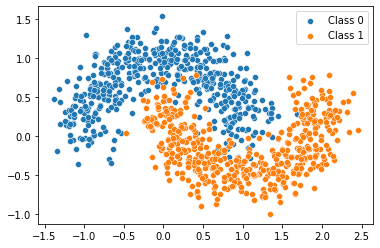

In [ ]:
sns.scatterplot(x=X[y == 0, 0], y=X[y == 0, 1])
sns.scatterplot(x=X[y == 1, 0], y=X[y == 1, 1])
plt.legend(labels = ["Class 0", "Class 1"])

### Build the Bayesian Neural Network

In [ ]:
n_hidden_layer_dim = 2

def build_neural_network(input_data, output_data):
  # Initialize random weights
  init_weights_1 = np.random.rand(input_data.shape[1], n_hidden_layer_dim).astype(floatX)
  init_weights_out = np.random.rand(n_hidden_layer_dim).astype(floatX)

  with pm.Model() as nn:
    input_data = pm.Data("input_data", X_train)
    output_data = pm.Data("output_data", y_train)

    """
      Define weights for all layers.
      Each weight will be initialy randomly initialized. In PyMC3 variables have an initial
      value as a start point, which can be changed at variable creation by specifying a 
      value for testval parameter.
    """
    weights_in_1 = pm.Normal("w_in_1", mu=0, sigma=1,
                             shape=(X.shape[1], n_hidden_layer_dim),
                             testval=init_weights_1)

    weights_1_out = pm.Normal("w_1_out", mu=0, sigma=1,
                              shape=(n_hidden_layer_dim,),
                              testval=init_weights_out)
    
    activation_1 = pm.math.tanh(pm.math.dot(input_data, weights_in_1))
    activation_2 = pm.math.sigmoid(pm.math.dot(activation_1, weights_1_out))
    output = pm.Bernoulli("out", activation_2,
                          observed=output_data,
                          total_size=y.shape[0])

    return nn

In [ ]:
neural_network = build_neural_network(X_train, y_train)

In [569]:
with neural_network:
  trace = pm.sample(draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w_1_out, w_in_1]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 51 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


# Sanity Check

The following figures show the posterior values of the weights of the model. It can be seen that the values correspond to the normal distribution, which was assumed to be the prior.

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


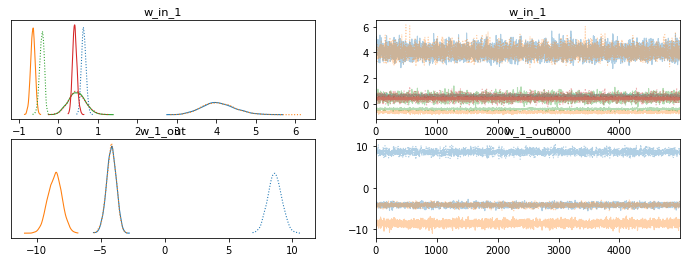

In [570]:
pm.traceplot(trace);

We set the number of samples for fitting the Bayesian neural network based on the parameters r_hat value. The model starts to converge when we set the number of samples to 5000.

In [ ]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"w_in_1[0, 0]",4.192,0.451,3.343,5.025,0.005,0.004,7064.0,5275.0,1.0
"w_in_1[0, 1]",-0.670,0.057,-0.776,-0.561,0.001,0.000,6864.0,6538.0,1.0
"w_in_1[1, 0]",0.486,0.200,0.116,0.858,0.002,0.002,7638.0,6768.0,1.0
"w_in_1[1, 1]",0.391,0.050,0.295,0.481,0.001,0.000,6645.0,6024.0,1.0
w_1_out[0],-4.066,0.380,-4.798,-3.382,0.005,0.003,6505.0,6153.0,1.0
w_1_out[1],-8.651,0.552,-9.682,-7.626,0.007,0.005,6317.0,5815.0,1.0


Run the model using the MCMC sampling algorithm to draw samples from the posterior distribution.

In [ ]:
"""
  After fitting the Bayesian NN on 5000 samples, we draw 5000 more from the 
  posterior distribution for both training and test sets.
"""
y_hat_train = pm.sample_posterior_predictive(trace, model=neural_network, samples=5000)["out"]
print('[NUTS] Accuracy on the training set: %.2f' % (np.mean(y_train == y_hat_train) * 100.))

[NUTS] Accuracy on the training set: 88.62


In [ ]:
pm.set_data(new_data={'input_data': X_test, 'output_data': y_test}, model=neural_network)
y_hat_test = pm.sample_posterior_predictive(trace, model=neural_network, samples=5000)["out"]
print('[NUTS] Accuracy on the test set: %.2f' % (np.mean(y_test == y_hat_test) * 100.))

[NUTS] Accuracy on the test set: 88.72


 Run the model using the variational inference algorithm to fit a distribution to the posterior. The advantage of this method is that it is much less expensive in terms of computational time, transforming the problem from a sampling one to an optimization one.

In [ ]:
pm.set_tt_rng(tt.random.utils.RandomStream(42))

In [ ]:
# "Train" the Bayesian NN
%%time

with neural_network:
  inference = pm.ADVI()
  var_post = pm.fit(n=36000, method=inference)

Finished [100%]: Average Loss = 152.4


CPU times: user 30.4 s, sys: 479 ms, total: 30.8 s
Wall time: 30.6 s


We can see from the figure above that the loss optimization slowly improves.

Text(0, 0.5, 'Loss function - Evidence Lower Bound')

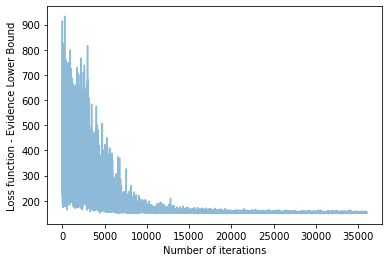

In [ ]:
plt.plot(var_post.hist, alpha=0.5)
plt.xlabel("Number of iterations")
plt.ylabel("Loss function - Evidence Lower Bound")

We can predict the labels using 2 strategies:

1.   We can use the "sample_posterior_predictive()" method to generate new data from the posterior (which comes from the variational estimation )
2.   Build back the graph (lazy evaluation)



In [ ]:
# 1st strategy

%timeit
pm.set_data(new_data={'input_data': X_test, 'output_data': y_test}, model=neural_network)
y_hat_test = pm.sample_posterior_predictive(trace, model=neural_network, samples=5000)["out"]
print('[AVDI] Accuracy on the test set: %.2f' % (np.mean(y_test == y_hat_test) * 100.))

[AVDI] Accuracy on the test set: 88.60


Text(0.5, 1.0, 'Predicted labels in test set')

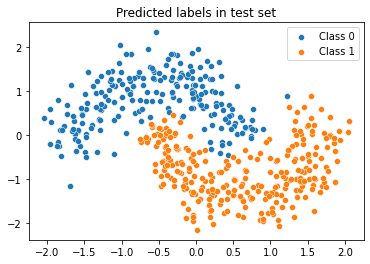

In [ ]:
y_pred = y_hat_test.mean(0) > 0.5
sns.scatterplot(x=X_test[y_pred == 0, 0], y=X_test[y_pred == 0, 1])
sns.scatterplot(x=X_test[y_pred == 1, 0], y=X_test[y_pred == 1, 1])
plt.legend(labels = ["Class 0", "Class 1"])
plt.title("Predicted labels in test set")

In [ ]:
%%time

x = tt.matrix("X")
n = tt.iscalar("n")
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100

sample_prob = theano.function([x, n], var_post.sample_node(
                                                  neural_network.out.distribution.p, 
                                                  size = n, 
                                                  more_replacements = {neural_network["input_data"]: x}
))

y_pred = sample_prob(X_test, 5000).mean(axis = 0) > 0.5

CPU times: user 631 ms, sys: 2.86 ms, total: 634 ms
Wall time: 637 ms


In [ ]:
print('[AVDI] Accuracy on the test set: %.2f' % (np.mean(y_test == y_pred) * 100.))

[AVDI] Accuracy on the test set: 85.40


Text(0.5, 1.0, 'Predicted labels in test set')

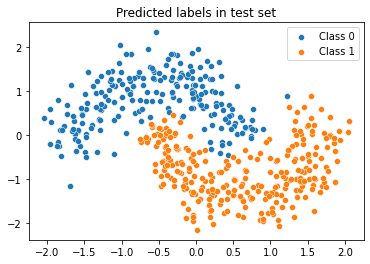

In [ ]:
y_pred = y_hat_test.mean(0) > 0.5
sns.scatterplot(x=X_test[y_pred == 0, 0], y=X_test[y_pred == 0, 1])
sns.scatterplot(x=X_test[y_pred == 1, 0], y=X_test[y_pred == 1, 1])
plt.legend(labels = ["Class 0", "Class 1"])
plt.title("Predicted labels in test set")

Comparision with a "classical" neural network.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(2, input_dim = X_train.shape[1], activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
16/16 [==============================] - 0s 2ms/step - loss: 1.0906 - accuracy: 0.2680
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 1.0259 - accuracy: 0.2980
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.9652 - accuracy: 0.3300
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.9087 - accuracy: 0.3660
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.8563 - accuracy: 0.4100
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.8079 - accuracy: 0.4540
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7642 - accuracy: 0.5300
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.5860
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.6360
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6660
Epoch 11/

In [ ]:
print ('[Classical NN] Accuracy on the test set: %.2f' % (model.evaluate(X_test, y_test)[1] * 100.))

16/16 [==============================] - 0s 2ms/step - loss: 0.3349 - accuracy: 0.8480
[Classical NN] Accuracy on the test set: 84.80


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(NeuralNetwork,self).__init__()
    self._input_size = input_size
    self._hidden_size = hidden_size

    self.fc1 = nn.Linear(self._input_size, self._hidden_size)
    self.fc2 = nn.Linear(self._hidden_size, 1)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x_ = self.tanh(self.fc1(x))
    y = self.sigmoid(self.fc2(x_))
    return y

In [ ]:
model = NeuralNetwork(X.shape[1], 2)

optimizer = optim.AdamW(model.parameters())
criterion = nn.BCELoss()

model.train()
for epoch in range(100):
  optimizer.zero_grad()
  # Forward pass
  y_pred = model(torch.FloatTensor(X_train))
  # Compute Loss
  loss = criterion(y_pred.squeeze(),torch.FloatTensor(y_train))
  
  # print('Epoch {}: train loss: {}'.format(epoch + 1, loss.item()))
  # Backward pass
  loss.backward()
  optimizer.step()

model.eval()
y_pred_test = model(torch.FloatTensor(X_test))
y_pred_test = y_pred_test.detach().numpy()

In [ ]:
y_pred_test = np.where(y_pred_test <= 0.5, 0, y_pred_test)
y_pred_test = np.where(y_pred_test > 0.5, 1, y_pred_test)

print('[Classical NN] Accuracy on the test set: %.2f' % (np.mean(y_test.squeeze() == y_pred_test) * 100.))

## Multiclass Classification

For the multiclass classification task we will use 'Iris' dataset (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html?highlight=iris#sklearn.datasets.load_iris).

In [ ]:
X_multi, y_multi = load_iris(return_X_y = True)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.5)

standard_scaler = StandardScaler()
X_train_multi, X_test_multi = standard_scaler.fit_transform(X_train_multi), standard_scaler.transform(X_test_multi)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = X_train_multi.astype(floatX), X_test_multi.astype(floatX), y_train_multi.astype(floatX), y_test_multi.astype(floatX)

In [ ]:
n_hidden_layer_dim = 3

def build_neural_network(input_data, output_data):
  # Initialize random weights
  init_weights_1 = np.random.rand(input_data.shape[1], n_hidden_layer_dim).astype(floatX)
  init_weights_out = np.random.rand(n_hidden_layer_dim).astype(floatX)

  with pm.Model() as nn:
    input_data = pm.Data("input_data", X_train_multi)
    output_data = pm.Data("output_data", y_train_multi)

    """
      Define weights for all layers.
      Each weight will be initialy randomly initialized. In PyMC3 variables have an initial
      value as a start point, which can be changed at variable creation by specifying a 
      value for testval parameter.
    """
    weights_in_1 = pm.Normal("w_in_1", mu=0, sigma=1,
                             shape=(X_multi.shape[1], n_hidden_layer_dim),
                             testval=init_weights_1)

    weights_1_out = pm.Normal("w_1_out", mu=0, sigma=1,
                              shape=(n_hidden_layer_dim,3),
                              testval=init_weights_out)
    
    # Forward pass 
    activation_1 = pm.math.tanh(pm.math.dot(input_data, weights_in_1))
    activation_2 = pm.math.sigmoid(pm.math.dot(activation_1, weights_1_out))
    output = pm.Categorical("out_multi", activation_2,
                            observed=output_data,
                            total_size=y_multi.shape[0])

    return nn

In [ ]:
neural_network_multi = build_neural_network(X_train_multi, y_train_multi)

In [ ]:
# "Train" the Bayesian NN
%%time

with neural_network_multi:
  inference = pm.ADVI()
  var_post = pm.fit(n=50000, method=inference)

Finished [100%]: Average Loss = 48.04


CPU times: user 42.1 s, sys: 571 ms, total: 42.7 s
Wall time: 42.6 s


Text(0.5, 0, 'Number of iterations')

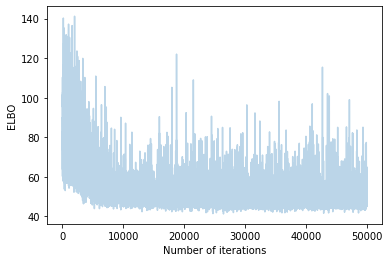

In [ ]:
plt.plot(var_post.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Number of iterations")

#### Sanity check

We will check what the model learnt.

In [ ]:
with neural_network_multi:
  trace = pm.sample(draws=5000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w_1_out, w_in_1]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 108 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"w_in_1[0, 0]",-0.064,0.721,-1.389,1.322,0.020,0.014,1242.0,2764.0,1.00
"w_in_1[0, 1]",-0.023,0.724,-1.368,1.327,0.023,0.016,970.0,2371.0,1.00
"w_in_1[0, 2]",-0.015,0.717,-1.379,1.328,0.021,0.015,1110.0,2780.0,1.00
"w_in_1[1, 0]",0.138,1.246,-2.105,2.238,0.076,0.054,249.0,635.0,1.00
"w_in_1[1, 1]",0.114,1.245,-2.094,2.166,0.073,0.052,278.0,857.0,1.02
"w_in_1[1, 2]",0.012,1.305,-2.205,2.214,0.087,0.061,190.0,1190.0,1.01
"w_in_1[2, 0]",-0.035,1.307,-2.324,2.363,0.143,0.102,89.0,1205.0,1.02
"w_in_1[2, 1]",-0.076,1.322,-2.464,2.251,0.137,0.097,98.0,831.0,1.03
"w_in_1[2, 2]",0.050,1.361,-2.362,2.514,0.180,0.128,61.0,1197.0,1.02
"w_in_1[3, 0]",0.031,1.615,-2.754,2.758,0.197,0.140,76.0,932.0,1.03


In [ ]:
%%time

x = tt.matrix("X")
n = tt.iscalar("n")
x.tag.test_value = np.empty_like(X_train_multi[:10])
n.tag.test_value = 100

sample_prob = theano.function([x, n], var_post.sample_node(
                                                  neural_network_multi.out_multi.distribution.p, 
                                                  size = n, 
                                                  more_replacements = {neural_network_multi["input_data"]: x}
))

y_pred_multi = sample_prob(X_test_multi, 75)

CPU times: user 250 ms, sys: 2.96 ms, total: 253 ms
Wall time: 258 ms


In [ ]:
y_pred_multi = np.argmax(y_pred_multi, axis=2)

In [ ]:
print('[AVDI] Accuracy on the test set: %.2f' % (np.mean(y_test_multi == y_pred_multi) * 100.))

[AVDI] Accuracy on the test set: 75.32


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim = X_train_multi.shape[1], activation='tanh'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_multi, y_train_multi, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4721 - accuracy: 0.0133
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4474 - accuracy: 0.0133
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4240 - accuracy: 0.0133
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4007 - accuracy: 0.0133
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3777 - accuracy: 0.0267
Epoch 6/100
3/3 [==============================] - 0s 7ms/step - loss: 1.3545 - accuracy: 0.0267
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 1.3335 - accuracy: 0.0400
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3117 - accuracy: 0.0533
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2910 - accuracy: 0.0667
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2696 - accuracy: 0.0800
Epoch 11/100
3/3 [===========

In [ ]:
print ('[Classical NN] Accuracy on the test set: %.2f' % (model.evaluate(X_test_multi, y_test_multi)[1] * 100.))

3/3 [==============================] - 0s 5ms/step - loss: 0.6074 - accuracy: 0.7333
[Classical NN] Accuracy on the test set: 73.33


Results show that the Bayesian Neural Network performed slightly better than the "Classical" Neural Networks.